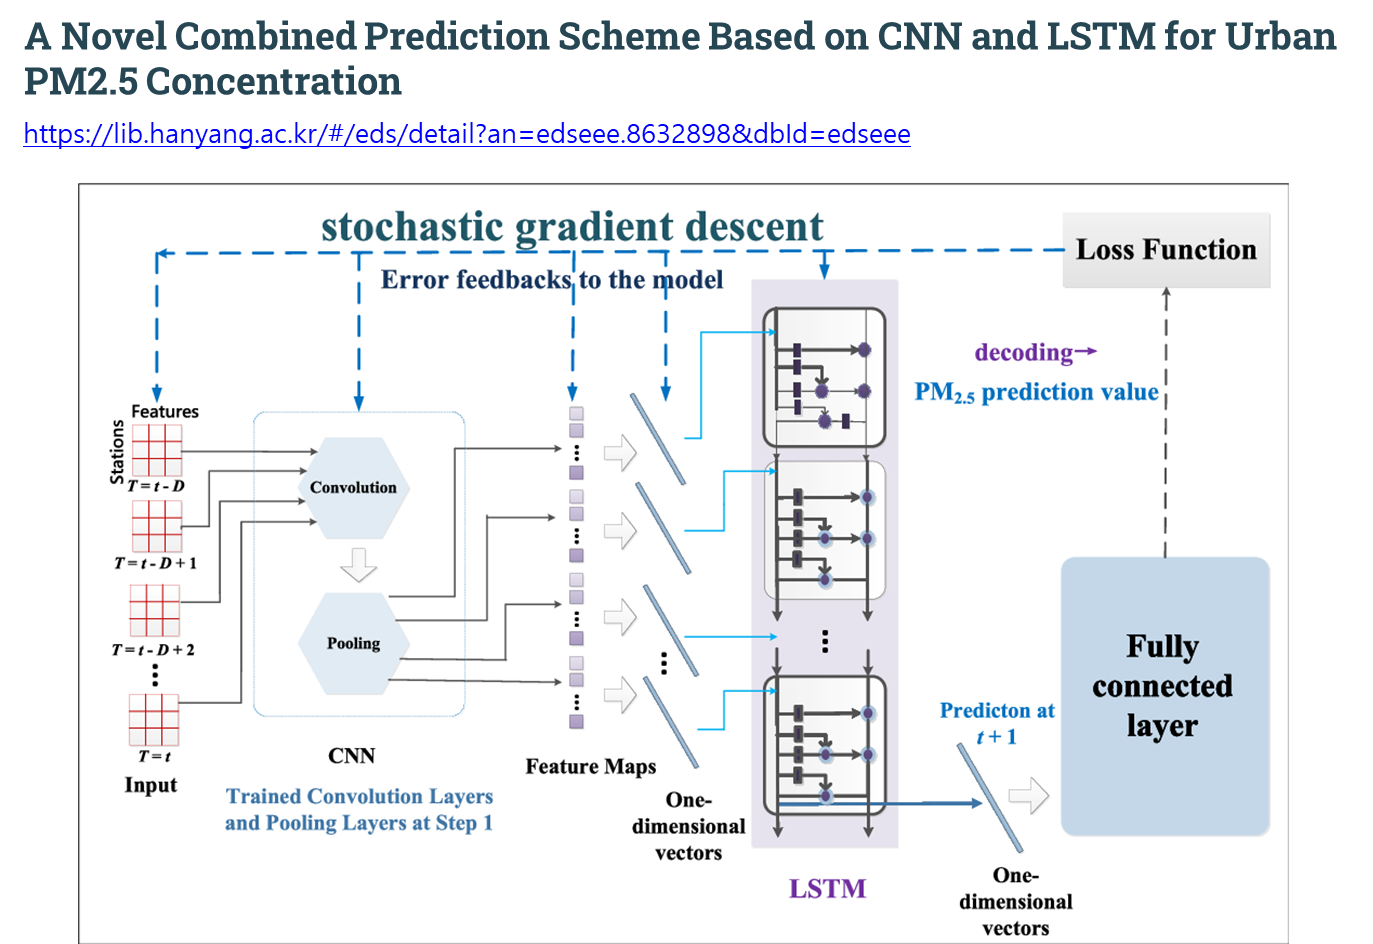

https://lib.hanyang.ac.kr/#/eds/detail?an=edseee.8632898&dbId=edseee

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LSTM, Dense, Flatten, TimeDistributed, Reshape,MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def initialize_city(grid_size=100, initial_points=4):
    """Initialize the city with a few initial urban points."""
    city = np.zeros((grid_size, grid_size))
    points = np.random.choice(range(grid_size * grid_size), initial_points, replace=False)
    for point in points:
        x, y = divmod(point, grid_size)
        city[x, y] = 1
    return city

def spread_urbanization(city, spread_prob_base=0.01, spread_prob_increment=0.002, slowdown_threshold=50, slowdown_factor=0.2, limit_threshold=2000):
    """Spread urbanization to neighboring cells based on an adaptive probability that decreases above a threshold."""
    grid_size = city.shape[0]
    new_city = city.copy()
    urban_count = np.sum(city)

    # Adjust spread probability based on the size of urbanized area
    if urban_count > slowdown_threshold:
        spread_prob_increment *= slowdown_factor  # Slow down expansion

    if urban_count > limit_threshold :
      return new_city

    for i in range(grid_size):
        for j in range(grid_size):
            if city[i, j] == 1:
                # Spread to neighboring cells if they are green (0)
                for x, y in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
                    if 0 <= x < grid_size and 0 <= y < grid_size and city[x, y] == 0:
                        spread_prob = spread_prob_base + spread_prob_increment * urban_count
                        if np.random.rand() < spread_prob:
                            new_city[x, y] = 1
    return new_city

def generate_city_data(grid_size=100, years=100, initial_points=4):
    """Generate city data over a period of years, starting from initial urban points."""
    city_data = np.zeros((years, grid_size, grid_size))
    city_data[0] = initialize_city(grid_size, initial_points)

    for year in range(1, years):
        city_data[year] = spread_urbanization(city_data[year - 1])

    return city_data

# Generate the city data
city_data = generate_city_data()
city_data = np.expand_dims(city_data, axis=-1)  # Add a channel dimension

# Visualize the city data at different years
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, year in enumerate([0, 25, 50, 75, 99]):
    axs[i].imshow(city_data[year], cmap="Reds")
    axs[i].set_title(f"Year {year}")
    axs[i].axis("off")
plt.show()


In [ ]:
# prompt: city_data 를 LSTM 시계열에 학습하기 위해서 과거 10년치로 다음 1년치 예측하게 train tes셋 만들어줘

import numpy as np

def create_sequences(data, seq_length_train, seq_length_predict):
    xs = []
    ys = []
    for i in range(len(data)-seq_length_train-seq_length_predict+1):
        x = data[i:(i+seq_length_train)]
        y = data[i+seq_length_train:(i+seq_length_train+seq_length_predict)]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Assuming city_data is your generated dataset
# Example usage: 10 years of past data to predict the next 1 year
seq_length_train = 10  # Past 10 years
seq_length_predict = 1 # Next 1 year

X, y = create_sequences(city_data, seq_length_train, seq_length_predict)

# Split into train and test sets (e.g., 80/20 split)
split_index = int(0.5 * len(X))
X_train = X[:split_index]
y_train = y[:split_index]
X_test = X[split_index:]
y_test = y[split_index:]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

In [ ]:

# Step 2: Build CNN-LSTM Model
timesteps, grid_size, _, channels = [10, 100, 100, 1]


# CNN-LSTM 모델 정의
model = Sequential()

# TimeDistributed를 사용하여 Conv2D 레이어 적용
model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=(timesteps, grid_size, grid_size, channels)))
model.add(TimeDistributed(MaxPooling2D((2, 2), padding='same')))  # 첫 번째 MaxPooling 적용

model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))
model.add(TimeDistributed(MaxPooling2D((2, 2), padding='same')))  # 두 번째 MaxPooling 적용

model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same')))
model.add(TimeDistributed(MaxPooling2D((2, 2), padding='same')))  # 세 번째 MaxPooling 적용

# 시계열 차원을 유지하면서 (25, 25, 128) 부분만 Flatten
model.add(TimeDistributed(Flatten()))

# LSTM 층 추가
model.add(LSTM(20, activation='relu', return_sequences=False))

# 최종 출력 레이어
model.add(Dense(grid_size * grid_size, activation='sigmoid'))
model.add(Reshape((1, grid_size, grid_size, 1)))

# 모델 컴파일
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

In [ ]:


# Step 3: Train the Model
history = model.fit(X_train, y_train, epochs=100, batch_size=16)  # Adjust epochs and batch_size as needed



In [ ]:

# Step 4: Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Step 5: Make Predictions
predictions = model.predict(X_test)
predictions = predictions.reshape(predictions.shape[0], grid_size, grid_size, 1)

# Visualize the city data at different years
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, year in enumerate([0, 10, 20, 30, 44]):
    axs[i].imshow(predictions[year], cmap="Reds")
    axs[i].set_title(f"Year {year}")
    axs[i].axis("off")
plt.show()

# Visualize the city data at different years
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, year in enumerate([50, 60, 70, 80, 94]):
    axs[i].imshow(city_data[year], cmap="Reds")
    axs[i].set_title(f"Year {year}")
    axs[i].axis("off")
plt.show()